In [62]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import Ipynb_importer
import softmax_from0


使用三阶多项式来生成训练和测试数据的标签

In [39]:
max_degree = 20 #多项式最大20阶
n_train, n_test = 100, 100 # 训练数据集，测试数据集
true_w = np.zeros(max_degree) # 分配大量空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size = (n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)
    # gamma(n)=(n-1)!
labels = np.dot(poly_features, true_w) # labels的维度
labels += np.random.normal(scale=0.1, size=labels.shape)

观测前两个样本

In [40]:
true_w, features,poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]
features[:2],poly_features[:2, :],labels[:2]



(tensor([[1.5591],
         [0.6725]]),
 tensor([[1.0000e+00, 1.5591e+00, 1.2154e+00, 6.3165e-01, 2.4620e-01, 7.6771e-02,
          1.9949e-02, 4.4432e-03, 8.6593e-04, 1.5001e-04, 2.3388e-05, 3.3149e-06,
          4.3069e-07, 5.1653e-08, 5.7524e-09, 5.9790e-10, 5.8262e-11, 5.3433e-12,
          4.6282e-13, 3.7978e-14],
         [1.0000e+00, 6.7246e-01, 2.2610e-01, 5.0681e-02, 8.5202e-03, 1.1459e-03,
          1.2843e-04, 1.2337e-05, 1.0370e-06, 7.7485e-08, 5.2106e-09, 3.1853e-10,
          1.7850e-11, 9.2334e-13, 4.4350e-14, 1.9882e-15, 8.3563e-17, 3.3055e-18,
          1.2349e-19, 4.3705e-21]]),
 tensor([6.4214, 5.4673]))

实现一个函数来评估模型在给定数据集上的损失

In [41]:

def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(),l.numel())
    return metric[0] / metric[1]

定义训练函数

In [60]:
def train(train_features, test_features, train_labels,test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设偏置值，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    animator = softmax_from0.Animator(xlabel='epoch', ylabel='loss',yscale='log',
                                     xlim=[1,num_epochs], ylim=[1e-3, 1e2],
                                     legend=['train','test'])
    for epoch in range(num_epochs):
        softmax_from0.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch+1)%20==0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss),
                                  evaluate_loss(net, test_iter, loss)))
    print('weight:',net[0].weight.data.numpy())

从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3! (正常拟合)

weight: [[ 4.989566   1.32675   -3.3463097  5.240407 ]]


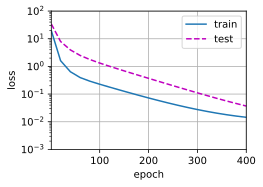

In [61]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.6751537 2.9016817]]


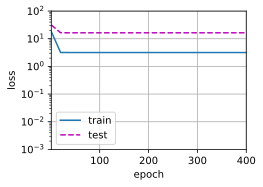

In [63]:
# 从多项式特征中选择前2个维度，即1和x （欠拟合）
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.0008984   1.2040075  -3.329637    5.4546094  -0.2665816   0.93002474
   0.04994435  0.12077454  0.16560955 -0.14144015  0.0448138  -0.2144096
   0.18482774 -0.11865523 -0.16008683 -0.20990838 -0.10956555 -0.11466463
  -0.15867767 -0.05858681]]


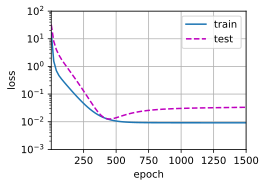

In [64]:
# 从多项式特征中选取所有维度 （过拟合）
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)